## 기초 모듈 불러오기

In [1]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from soynlp.normalizer import *
from hanspell import spell_checker
from konlpy.tag import Okt

# ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# 한글화
import koreanize_matplotlib 

## 파일 불러오기 및 말뭉치 만들기

In [2]:
# 파일 불러오기

review_df = pd.read_csv('./[JHS]preprocessed_data.csv', encoding='utf-8', index_col=0) # df_review는 전체년도 리뷰 크롤링 파일
review_df.head()

,date,review,rating,review_tokens,review_tokens_removeST,review_tokens_removeST_vec,label
0,2023-09-10,상세 설명에 들어가지 않아도 검색 결과에서 중량과 가격이 바로 확인되면 더 편리하겠습니다,5,"['상세', '설명', '검색', '결과', '중량', '가격', '바로', '확인...","['가격', '설명', '상세', '중량']",가격 설명 상세 중량,1
1,2023-09-09,필터 기능 잘 되어있어 편하게 쇼핑함,5,"['필터', '기능', '쇼핑', '함']","['기능', '필터']",기능 필터,1
2,2023-09-09,배송이 빨라요 그리고 할인이 많아요,5,"['배송', '할인']","['배송', '할인']",배송 할인,1
3,2023-09-09,50퍼 쿠폰 만원 빵빵하게 주는 곳 처음 봄 주문하면 6시간 만에 옴 이 앱 뭐지,5,"['쿠폰', '만원', '빵빵', '곳', '처음', '봄', '주문', '옴', ...","['만원', '쿠폰', '주문']",만원 쿠폰 주문,1
4,2023-09-09,빠른 배송,5,['배송'],['배송'],배송,1


In [3]:
len(review_df)

9926

In [4]:
## 말뭉치 만들기

import ast

nouns_list = []

for tokens in review_df['review_tokens_removeST']:
    
    nouns_list.extend(ast.literal_eval(tokens))
    
nouns_list_set = list(set(nouns_list))
print('토큰화 말뭉치 개수 :',len(nouns_list))
print('중복을 제거한 말뭉치 개수 :',len(nouns_list_set))

토큰화 말뭉치 개수 : 46215
중복을 제거한 말뭉치 개수 : 4686


In [5]:
nouns_list[:10]

['가격', '설명', '상세', '중량', '기능', '필터', '배송', '할인', '만원', '쿠폰']

## 파이프라인 에서 나온 베스트 모델

##### 말뭉치 기준 벡터화

In [16]:
# 벡터화
best_vectorizer = TfidfVectorizer(min_df=1, decode_error='ignore',vocabulary=nouns_list_set) # max_features=3000

contents_for_vectorize = review_df['review_tokens_removeST_vec']
X = best_vectorizer.fit_transform(contents_for_vectorize)
X.shape

(9926, 4686)

In [17]:
y = review_df['label']
y.shape

(9926,)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

best_model = LogisticRegression(C=5,l1_ratio=0.25,max_iter=1000,solver='saga', penalty='elasticnet', random_state=13)
best_model.fit(X_train, y_train)

y_pred_tr = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

print('Train Acc : ', accuracy_score(y_train, y_pred_tr))
print('Test Acc : ', accuracy_score(y_test, y_pred_test))

Train Acc :  0.9423173803526448
Test Acc :  0.8846928499496476


## 오즈비

로지스틱 회귀 함수를 돌고 나온것은 선형관계식임, 즉, 오즈비를 구할라면 선형관계식의 계수에 e를 취하면 구할 수 있다.<br><br>
성공, 실패에 얼마나 영향을 끼치냐를 볼 때, 함수에서 나온 결과는 선형관계식일 때의 계수이기 때문에 <br>
실제 얼마나 영향을 끼치냐는 오즈비로 보는 것 이다...?
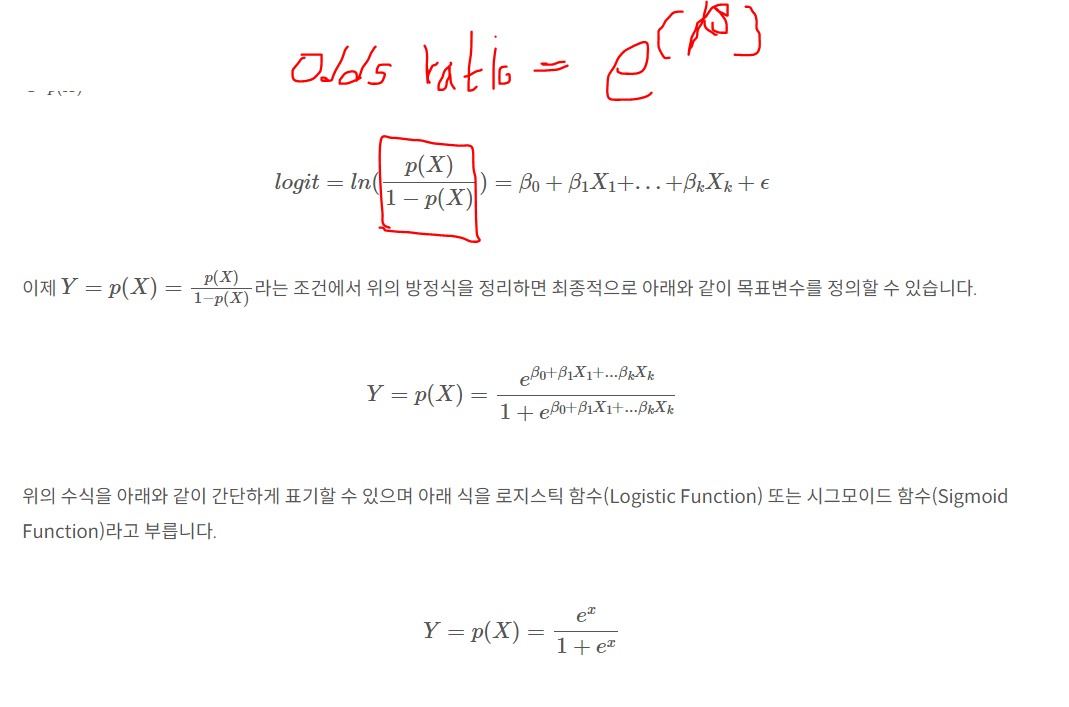

In [19]:
best_model.coef_

array([[-0.94221811,  0.        , -2.19712772, ...,  0.        ,
        -1.68337017,  0.39598597]])

In [20]:
best_model.coef_[0][0]

-0.9422181067500155

In [21]:
odds_ratio = []
for coef in best_model.coef_[0]:
    odds_ratio.append(np.exp(coef))

In [22]:
odds_ratio

[0.38976234135406745,
 1.0,
 0.11112187379502925,
 2.1170752826246964,
 1.0,
 1.627875275184286,
 1.0,
 0.06776186124342679,
 1.0,
 1.0,
 1.0,
 1.0,
 0.6907915707432633,
 3.148746854428523,
 1.0,
 0.11034470232036124,
 1.2400229817877626,
 1.0,
 1.0,
 0.3069757933408569,
 1.0,
 1.0,
 0.19658631686082542,
 1.0,
 1.0,
 0.9739935904324402,
 1.0,
 1.6647060678923498,
 1.0,
 1.3552497362931346,
 0.8480390370225642,
 1.0,
 0.7680981937708296,
 0.8172147298682865,
 1.2258204452422123,
 0.47023303216310425,
 1.1894869079042396,
 0.3955468517342684,
 0.5023516539092308,
 2.764184526972,
 1.0,
 1.1268016186844574,
 0.2941689201871078,
 16.543231831500425,
 1.1701452150366507,
 1.0,
 1.7848474766018074,
 0.5815902556964785,
 0.3819353940252791,
 3.2340711590415983,
 1.0,
 0.12706709888557394,
 1.3343431778897257,
 1.0,
 10.267682622421592,
 1.9472183507475926,
 0.5203588988025883,
 1.0,
 1.0639037641185638,
 1.0,
 1.2335778447890895,
 1.235031964009998,
 0.7892471603142417,
 1.0,
 1.0,
 1.2934555

In [23]:
best_vectorizer.vocabulary_

{'인터페이스': 0,
 '촘촘하': 1,
 '보도': 2,
 '휴면': 3,
 '쌈': 4,
 '구색': 5,
 '기': 6,
 '서버': 7,
 '납품': 8,
 '쪼그': 9,
 '지라니': 10,
 '웹': 11,
 '화도': 12,
 '모습': 13,
 '좋아욛': 14,
 '가가': 15,
 '언급': 16,
 '대대': 17,
 '요금': 18,
 '시점': 19,
 '멜론': 20,
 '비료': 21,
 '인력': 22,
 '실감': 23,
 '대낮': 24,
 '깝깝': 25,
 '키빅': 26,
 '누르기': 27,
 '고매': 28,
 '현황': 29,
 '지금껏': 30,
 '상점': 31,
 '전제': 32,
 '사과문': 33,
 '바램': 34,
 '코로': 35,
 '치매': 36,
 '타이밍': 37,
 '예시': 38,
 '조음': 39,
 '순식간': 40,
 '볶음': 41,
 '호불호': 42,
 '신세계': 43,
 '처음처럼': 44,
 '해주시': 45,
 '만하': 46,
 '여지': 47,
 '베스': 48,
 '사용자': 49,
 '킹': 50,
 '기숙사': 51,
 '싱글': 52,
 '취했다': 53,
 '재활용': 54,
 '한자리': 55,
 '골목길': 56,
 '별반': 57,
 '리트': 58,
 '이요': 59,
 '자동차': 60,
 '배려': 61,
 '상대로': 62,
 '오븐': 63,
 '예서': 64,
 '짝짝': 65,
 '할인': 66,
 '접수': 67,
 '나시': 68,
 '건가': 69,
 '블러': 70,
 '조작': 71,
 '앨': 72,
 '위원회': 73,
 '외출': 74,
 '이행': 75,
 '이벤트': 76,
 '오류로': 77,
 '지점': 78,
 '호기심': 79,
 '실실': 80,
 '리기': 81,
 '편임': 82,
 '전통': 83,
 '절반': 84,
 '부유': 85,
 '종일': 86,
 '비닐': 87,
 '승인': 88,
 '케이': 8

In [24]:
# 단어 사전에서 인덱스, 값으로 위치 변경
id_to_word = {v: k for k, v in best_vectorizer.vocabulary_.items()}
print(id_to_word)

{0: '인터페이스', 1: '촘촘하', 2: '보도', 3: '휴면', 4: '쌈', 5: '구색', 6: '기', 7: '서버', 8: '납품', 9: '쪼그', 10: '지라니', 11: '웹', 12: '화도', 13: '모습', 14: '좋아욛', 15: '가가', 16: '언급', 17: '대대', 18: '요금', 19: '시점', 20: '멜론', 21: '비료', 22: '인력', 23: '실감', 24: '대낮', 25: '깝깝', 26: '키빅', 27: '누르기', 28: '고매', 29: '현황', 30: '지금껏', 31: '상점', 32: '전제', 33: '사과문', 34: '바램', 35: '코로', 36: '치매', 37: '타이밍', 38: '예시', 39: '조음', 40: '순식간', 41: '볶음', 42: '호불호', 43: '신세계', 44: '처음처럼', 45: '해주시', 46: '만하', 47: '여지', 48: '베스', 49: '사용자', 50: '킹', 51: '기숙사', 52: '싱글', 53: '취했다', 54: '재활용', 55: '한자리', 56: '골목길', 57: '별반', 58: '리트', 59: '이요', 60: '자동차', 61: '배려', 62: '상대로', 63: '오븐', 64: '예서', 65: '짝짝', 66: '할인', 67: '접수', 68: '나시', 69: '건가', 70: '블러', 71: '조작', 72: '앨', 73: '위원회', 74: '외출', 75: '이행', 76: '이벤트', 77: '오류로', 78: '지점', 79: '호기심', 80: '실실', 81: '리기', 82: '편임', 83: '전통', 84: '절반', 85: '부유', 86: '종일', 87: '비닐', 88: '승인', 89: '케이', 90: '주황색', 91: '반려', 92: '십여', 93: '검색어', 94: '떡볶이', 95: '생산', 96: '비늘', 97: '블랙', 98:

In [25]:
## 오즈비, 계수, 인덱스 순서로 추출
coef_index = sorted(((np.exp(value), value, index) for index, value in enumerate(best_model.coef_[0])), reverse = False)
coef_neg_index = coef_index[:10]
coef_pos_index = coef_index[-10:]
#print(coef_pos_index[-3:])
#print(coef_neg_index [:3])
print(coef_index[0])

(0.0020662230116531314, -6.182032970425229, 4394)


## 오즈비 시각화

In [26]:
pos_top_word=[] 
pos_top_score=[]
for coef in coef_pos_index:
    print(id_to_word[coef[2]], round(coef[0],2))
    pos_top_word.append(id_to_word[coef[2]])
    pos_top_score.append(round(coef[0],2))

neg_top_word=[] 
neg_top_score=[]
for coef in coef_neg_index:
    print(id_to_word[coef[2]], round(coef[0],2))
    neg_top_word.append(id_to_word[coef[2]])
    neg_top_score.append(round(coef[0],2))

재료 12.49
배송 12.66
코로나 14.25
온라인 15.82
감동 16.19
신세계 16.54
만족 25.18
장보기 25.21
먹거리 26.53
포장 30.57
최악 0.0
엉망 0.0
오아시스 0.01
오류로 0.01
입력 0.01
회원 0.01
문의 0.01
업데이트 0.01
워드 0.01
포함 0.01


In [27]:
import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    print("Hangul set complete in your MAC!")
    rc("font", family = "Arial Unicode MS")
    
elif platform.system() == "Windows":
    print("Hangul set complete in your Windows!")
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc("font", family = font_name)

else:
    print("Unknown your system....")
    
plt.rcParams["axes.unicode_minus"] = False

def seaborn_Hangul():
    ## seaborn 한글
    plt.rc("font", family = "Malgun Gothic")
    sns.set(font="Malgun Gothic", 
    rc={"axes.unicode_minus":False}, style='white')
seaborn_Hangul();

Hangul set complete in your Windows!


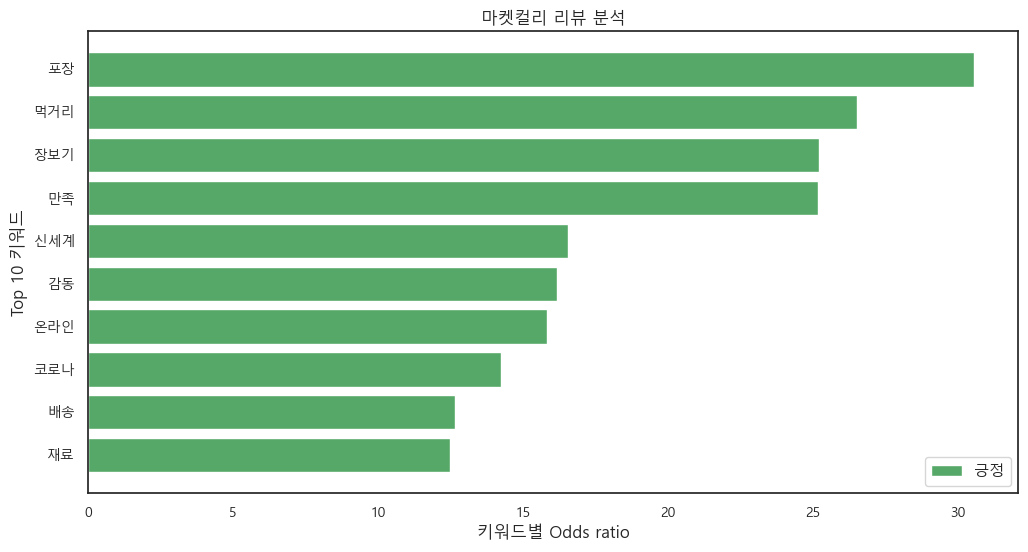

In [28]:
plt.figure(figsize=[12, 6])
#plt.barh(neg_top_word, neg_top_score, label = "부정", color = 'r')
plt.barh(pos_top_word, pos_top_score, label = "긍정", color = 'g')
plt.legend()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.xlabel('키워드별 Odds ratio')
plt.ylabel('Top 10 키워드')
plt.title('마켓컬리 리뷰 분석')
plt.show()

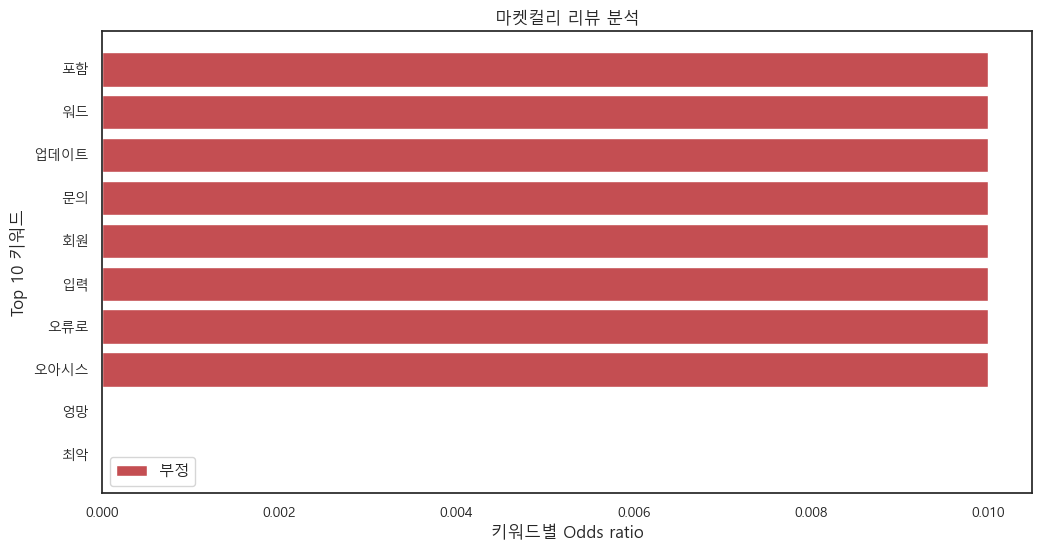

In [29]:
plt.figure(figsize=[12, 6])
plt.barh(neg_top_word, neg_top_score, label = "부정", color = 'r')
#plt.barh(pos_top_word, pos_top_score, label = "긍정", color = 'g')
plt.legend()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.xlabel('키워드별 Odds ratio')
plt.ylabel('Top 10 키워드')
plt.title('마켓컬리 리뷰 분석')
plt.show()

오즈비가 1을 기준으로해서 오즈비 10과 오즈비 0.1이 같은 영향치를 의미한다.....

## 그래프로 나타내기 힘드므로... 그냥 표로

In [30]:
from IPython.display import display_html
def display_side_by_side(*args):
    """여러 데이터프레임 비교가 쉽게 옆쪽으로 표시한다"""
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

In [31]:
top10_pos_odds = pd.DataFrame(list(zip(pos_top_word, pos_top_score)), columns=['키워드', '오즈비'])
top10_neg_odds = pd.DataFrame(list(zip(neg_top_word, neg_top_score)), columns=['키워드', '오즈비'])

print('------상위------', '-------하위------')
display_side_by_side(top10_pos_odds.sort_values(by='오즈비', ascending=False, ignore_index=True),
                     top10_neg_odds.sort_values(by='오즈비', ascending=True,ignore_index=True))

------상위------ -------하위------


,키워드,오즈비
0,포장,30.57
1,먹거리,26.53
2,장보기,25.21
3,만족,25.18
4,신세계,16.54
5,감동,16.19
6,온라인,15.82
7,코로나,14.25
8,배송,12.66
9,재료,12.49


## 말뭉치 빈도수 

In [32]:
from collections import Counter

counts_nouns_list = Counter(nouns_list)
counts_nouns_df = pd.DataFrame.from_dict([counts_nouns_list]).T
counts_nouns_df.columns = ['빈도수']
counts_nouns_df

print('------상위-----', '------하위-----')
display_side_by_side(counts_nouns_df.sort_values(by='빈도수', ascending=False).head(10),
                     counts_nouns_df.sort_values(by='빈도수', ascending=True).head(10))

------상위----- ------하위-----


,빈도수
배송,2670
상품,1361
제품,924
주문,903
쿠폰,652
새벽,612
구매,584
포장,519
가격,451
장바구니,431


## 오즈비 vs 빈도수 

In [33]:
print('--------------긍정--------------', '--------------부정--------------')
print('--------------------------------', '--------------------------------')

display_side_by_side(top10_pos_odds.sort_values(by='오즈비', ascending=False, ignore_index=True),
                     counts_nouns_df.sort_values(by='빈도수', ascending=False).head(10),
                     top10_neg_odds.sort_values(by='오즈비', ascending=True,ignore_index=True),
                    counts_nouns_df.sort_values(by='빈도수', ascending=True).head(10))

--------------긍정-------------- --------------부정--------------
-------------------------------- --------------------------------


,키워드,오즈비
0,포장,30.57
1,먹거리,26.53
2,장보기,25.21
3,만족,25.18
4,신세계,16.54
5,감동,16.19
6,온라인,15.82
7,코로나,14.25
8,배송,12.66
9,재료,12.49


오즈비(계수) 순서로 뽑은 키워드와 빈도수 키워드가 살짝 다르네
 - 오즈비 하위/ 빈도수 하위 에서 빈도수가 1인 키워드가 많을 거같아서 
    빈도수는 최소 2 이상이 되야되지 않을 까....? 좀 더 잡아서 한 10정도로?
    
    